### Imagenet

Largest image classification dataset at this point of time.

Url: http://image-net.org/

Our setup: classify from a set of 1000 classes.

In [1]:
#classes' names are stored here
import pickle
classes = pickle.load(open('classes.pkl','rb'))
print (classes[::100])

['tench, Tinca tinca', 'black swan, Cygnus atratus', 'Tibetan terrier, chrysanthemum dog', 'tiger beetle', "academic gown, academic robe, judge's robe", 'cliff dwelling', 'hook, claw', 'paper towel', 'slot, one-armed bandit', 'water tower']


### Using pre-trained model: inception
Keras has a number of models for which you can use pre-trained weights. The interface is super-straightforward:

In [2]:
import tensorflow as tf

In [53]:
import keras
import keras.applications as zoo

model = zoo.InceptionV3(include_top=True, weights='imagenet')

In [54]:
# model.summary()

### Predict class probabilities

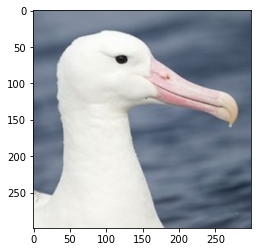

top-10 classes are:
0.1434	nematode
0.0709	matchstick
0.0414	digital clock
0.0223	jack-o'-lantern
0.0182	spotlight
0.0172	vine snake
0.0146	lighter
0.0111	candle
0.0104	drumstick


In [55]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('albatross.jpg'), (299,  299))
plt.imshow(img)
plt.show()

img_preprocessed = zoo.inception_v3.preprocess_input(img[None].astype('float32'))

probs = model.predict(img_preprocessed)

labels = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are:')
for l in labels:
    print ('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

### Having fun with pre-trained nets

In [60]:
!wget https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg -O img.jpg

--2021-03-13 01:33:47--  https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 2620:0:862:ed1a::2:b, 91.198.174.208
Connecting to upload.wikimedia.org (upload.wikimedia.org)|2620:0:862:ed1a::2:b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13726 (13K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  13,40K  --.-KB/s    in 0,001s  

2021-03-13 01:33:47 (12,0 MB/s) - ‘img.jpg’ saved [13726/13726]



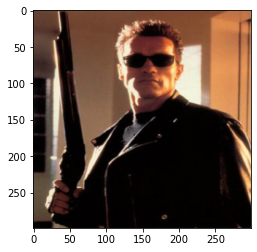

top-10 classes are:
0.0856	matchstick
0.0515	nematode
0.0366	digital clock
0.0281	jack-o'-lantern
0.0207	spotlight
0.0188	lighter
0.0164	drumstick
0.0162	jellyfish
0.0160	abaya


In [61]:
img = resize(plt.imread('img.jpg'), (299,299))
plt.imshow(img)
plt.show()

img_preprocessed = zoo.inception_v3.preprocess_input(img[None].astype('float32'))

probs = model.predict(img_preprocessed)

labels = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are:')
for l in labels:
    print ('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))



### How do you reuse layers

Since model is just a sequence of layers, one can apply it as any other Keras model. Then you can build more layers on top of it, train them and maybe fine-tune "body" weights a bit.

In [14]:
# img = keras.backend.Input('float32',[None,299,299,3])

neck = zoo.InceptionV3(include_top=False, weights='imagenet')(img[None])

hid = keras.layers.GlobalMaxPool2D()(neck)

hid = keras.layers.Dense(512,activation='relu')(hid)

out = keras.layers.Dense(10,activation='softmax')(hid)

#<...> loss, training, etc.

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = imresize(img,(IMAGE_W,IMAGE_W))
    img = zoo.inception_v3.preprocess_input(img[None].astype('float32'))
    
    features = <use network to process the image into features>
    Y.append(y)
    X.append(features)

In [ ]:

X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [ ]:
<split data either here or use cross-validation>

__load our dakka__

![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by setting var_list in the optimizer
      * `opt = tf.train.AdamOptimizer(learning_rate=...)`
      * `opt.minimize(loss,var_list=variables_you_wanna_train)`
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * you can create two update operations
      * `opt1 = tf.train.AdamOptimizer(learning_rate=lr1)`
      * `opt1.minimize(loss,var_list=head_weights)`
      * `opt2 = tf.train.AdamOptimizer(learning_rate=lr2)`
      * `opt2.minimize(loss,var_list=body_weights)`
 
### Grading
* 95% accuracy on test yields 100 points
* -10 points per 5% less accuracy

### Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 96%/97%/98%/99%/99.5% test score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [ ]:
#<A whole lot of your code>